# Initial training

In [137]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd



path = 'smoke_detection_iot.csv'

data = pd.read_csv(path).drop(['Unnamed: 0', 'UTC', 'CNT'], axis=1)
Y_df = data['Fire Alarm']
X_df = data.drop('Fire Alarm', axis=1)

Y_test_raw = X_df.values
Y_raw = Y_df.values

X_train_raw, X_test_raw, Y_train_raw, Y_test_raw = train_test_split(Y_test_raw, Y_raw, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_raw = scaler.fit_transform(X_train_raw)
X_test_raw = scaler.transform(X_test_raw)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


----------------------------------------
| Epoch | Training Loss |  Test Loss   |
----------------------------------------
|     0 |  0.7095817327 | 0.6559730172 |
----------------------------------------
|   100 |  0.0408540815 | 0.0410730951 |
----------------------------------------
|   200 |  0.0141550265 | 0.0146898208 |
----------------------------------------
|   300 |  0.0079696393 | 0.0079711424 |
----------------------------------------
|   400 |  0.0047452874 | 0.0048906831 |
----------------------------------------
|   500 |  0.1399636865 | 0.2152706385 |
----------------------------------------
|   600 |  0.0042813183 | 0.0039720731 |
----------------------------------------
|   700 |  0.0036226795 | 0.0033998650 |
----------------------------------------
|   800 |  0.0031731203 | 0.0029539394 |
----------------------------------------
|   900 |  0.0027904101 | 0.0025953513 |
----------------------------------------
|  1000 |  0.0024574571 | 0.0022893206 |
----------------

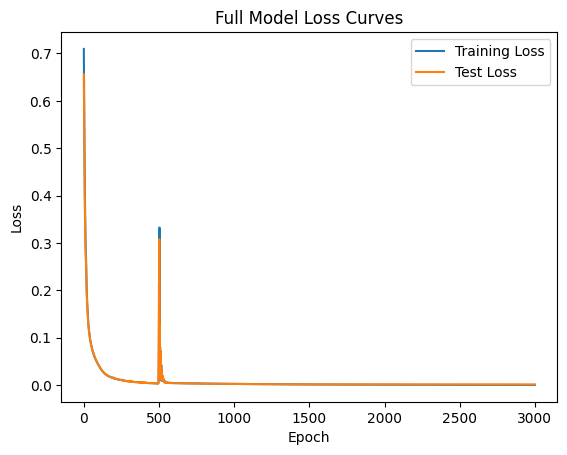

In [138]:
from alarmnetclass import AlarmNet
import torch
from torch import nn

alpha = 1e-2
epochs = 3000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
full_model = AlarmNet(
    num_features=X_train_raw.shape[1],
    activation = nn.ReLU,
    hidden_layers=[64, 32]
    
).to(device)

X_train_raw_device = torch.tensor(X_train_raw).float().to(device)
X_test_raw_device = torch.tensor(X_test_raw).float().to(device)
Y_train_raw_device = torch.tensor(Y_train_raw).float().view(-1, 1).to(device)
Y_test_raw_device = torch.tensor(Y_test_raw).float().view(-1, 1).to(device)

full_model.train(
    epochs=3000,
    X_train=X_train_raw_device,
    X_test=X_test_raw_device,
    Y_train=Y_train_raw_device,
    Y_test=Y_test_raw_device,
    alpha=1e-2,
    print_epoch = 100
)
full_model.print_results()
full_model.plot_training("Full Model Loss Curves")

# Feature Analysis
- Initially there are 15 features
- 3 are unusable
    - UTC Timestamp
    - CNT
    - Unnamed: 0
- 12 features are usable

In [139]:
import numpy as np



corr = np.abs(data.corr())
ranking = corr['Fire Alarm'].sort_values(ascending=False)[1:]
print(ranking)

Humidity[%]       0.399846
Raw Ethanol       0.340652
Pressure[hPa]     0.249797
TVOC[ppb]         0.214743
Temperature[C]    0.163902
NC0.5             0.128118
PM1.0             0.110552
Raw H2            0.107007
eCO2[ppm]         0.097006
PM2.5             0.084916
NC1.0             0.082828
NC2.5             0.057707
Name: Fire Alarm, dtype: float64


In [140]:
num_drops = 8
remaining_features = ranking.index[:-num_drops]


X_df_dropped = data[remaining_features]
print('Remaining features:', X_df_dropped.columns)
X_train_dropped, X_test_dropped, Y_train_dropped, Y_test_dropped = train_test_split(X_df_dropped.values, Y_raw, test_size=0.2, random_state=0)

X_train_dropped = scaler.fit_transform(X_train_dropped)
X_test_dropped = scaler.transform(X_test_dropped)


Remaining features: Index(['Humidity[%]', 'Raw Ethanol', 'Pressure[hPa]', 'TVOC[ppb]'], dtype='object')


----------------------------------------
| Epoch | Training Loss |  Test Loss   |
----------------------------------------
|     0 |  0.6541523337 | 0.6474413276 |
----------------------------------------
|   500 |  0.0900861546 | 0.0922125354 |
----------------------------------------
|  1000 |  0.0334825441 | 0.0342758819 |
----------------------------------------
|  1500 |  0.0150497574 | 0.0161326211 |
----------------------------------------
|  2000 |  0.0089510009 | 0.0102235219 |
----------------------------------------
|  2500 |  0.0058779898 | 0.0071429224 |
----------------------------------------
|  3000 |  0.0040493850 | 0.0052188532 |
----------------------------------------
|  3500 |  0.0028398184 | 0.0039309082 |
----------------------------------------
|  3999 |  0.0020102009 | 0.0030622981 |
----------------------------------------
Accuracy: 0.9991218266006706
Precision: 0.9991037418776607
Recall: 0.999663714830176
F1: 0.9993836499131507
Confusion_matrix:
[[3597    8]


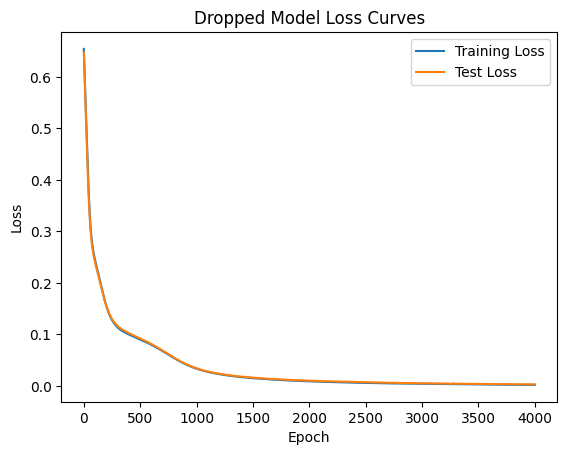

In [141]:
dropped_model = AlarmNet(
    num_features=X_train_dropped.shape[1],
    activation = nn.ReLU,
    hidden_layers=[64, 64]
    
).to(device)

X_train_dropped_device = torch.tensor(X_train_dropped).float().to(device)
X_test_dropped_device = torch.tensor(X_test_dropped).float().to(device)
Y_train_dropped_device = torch.tensor(Y_train_dropped).float().view(-1, 1).to(device)
Y_test_dropped_device = torch.tensor(Y_test_dropped).float().view(-1, 1).to(device)

dropped_model.train(
    epochs=4000,
    X_train=X_train_dropped_device,
    X_test=X_test_dropped_device,
    Y_train=Y_train_dropped_device,
    Y_test=Y_test_dropped_device,
    alpha=1e-3,
    print_epoch = 500
)
dropped_model.print_results()
AlarmNet.compare_results(dropped_model.get_results(), full_model.get_results())
dropped_model.plot_training("Dropped Model Loss Curves")

## Feature Analysis Results
- We can remove the bottom 8 features and have a model that only loses 0.1% precision, and even less for every other metric
- A 4 feature model is almost perfect
    - These features are:
        - Humidity
        - Raw Ethanol
        - Pressure
        - TVOC
- Note that the Particulate Matter sensor is not included in the 4-feature model.
    - To add redundancy to our model, we can add back the most correlated feature from the PM sensor
    - This feature is PM0.5




In [142]:

# Add back the most correlated PM feature, so that all 4 sensors are used
# PM0.5 is the most correlated PM feature, with index 5
remaining_features_2 = list(remaining_features)
remaining_features_2.append(ranking.index[5])
X_5f = data[remaining_features_2]
X_train_5f, X_test_5f, Y_train_5f, Y_test_5f = train_test_split(X_5f, Y_df, test_size=0.2, random_state=0)



scaler = StandardScaler()
X_train_5f_scaled = scaler.fit_transform(X_train_5f)
X_test_5f_scaled = scaler.transform(X_test_5f)

----------------------------------------
| Epoch | Training Loss |  Test Loss   |
----------------------------------------
|     0 |  0.7198916078 | 0.6520622969 |
----------------------------------------
|   500 |  0.0130791422 | 0.0134262340 |
----------------------------------------
|  1000 |  0.0092292232 | 0.0096894745 |
----------------------------------------
|  1500 |  0.0051953942 | 0.0055527696 |
----------------------------------------
|  2000 |  0.0031999548 | 0.0034894918 |
----------------------------------------
|  2500 |  0.0020762302 | 0.0022848581 |
----------------------------------------
|  2999 |  0.0013973819 | 0.0015664292 |
----------------------------------------
Accuracy: 0.9998403321092129
Precision: 1.0
Recall: 0.9997758098867839
F1: 0.9998878923766816
Confusion_matrix:
[[3605    0]
 [   2 8919]]
Classification_report:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3605
         1.0       1.00      1.0

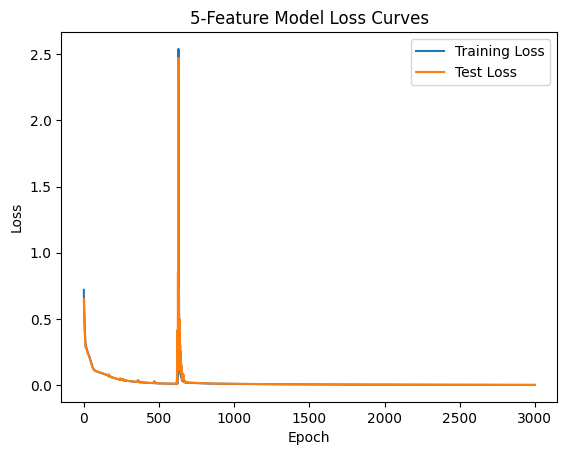

In [143]:

dropped_model_5 = AlarmNet(
    num_features=X_train_5f_scaled.shape[1],  # Update to match the new input dimensions
    activation = nn.ReLU,
    hidden_layers=[64, 32]
    
).to(device)
epochs = 3000
alpha = 1e-2

X_train_5f_device = torch.tensor(X_train_5f_scaled).float().to(device)
X_test_5f_device = torch.tensor(X_test_5f_scaled).float().to(device)
Y_train_5f_device = torch.tensor(Y_train_raw).float().view(-1, 1).to(device)
Y_test_5f_device = torch.tensor(Y_test_raw).float().view(-1, 1).to(device)

dropped_model_5.train(epochs, X_train_5f_device, X_test_5f_device, Y_train_5f_device, Y_test_5f_device, alpha)

dropped_model_5_results = dropped_model_5.get_results()
dropped_model_5.print_results()

AlarmNet.compare_results(dropped_model_5_results, full_model.get_results())

dropped_model_5.plot_training("5-Feature Model Loss Curves")


# Outlier Removal
- The curve above has an odd spike in the middle of training. This may be due to the heavily biased distributions of the NC0.5 and TVOC features

array([[<Axes: title={'center': 'Humidity[%]'}>,
        <Axes: title={'center': 'Raw Ethanol'}>],
       [<Axes: title={'center': 'Pressure[hPa]'}>,
        <Axes: title={'center': 'TVOC[ppb]'}>],
       [<Axes: title={'center': 'NC0.5'}>, <Axes: >]], dtype=object)

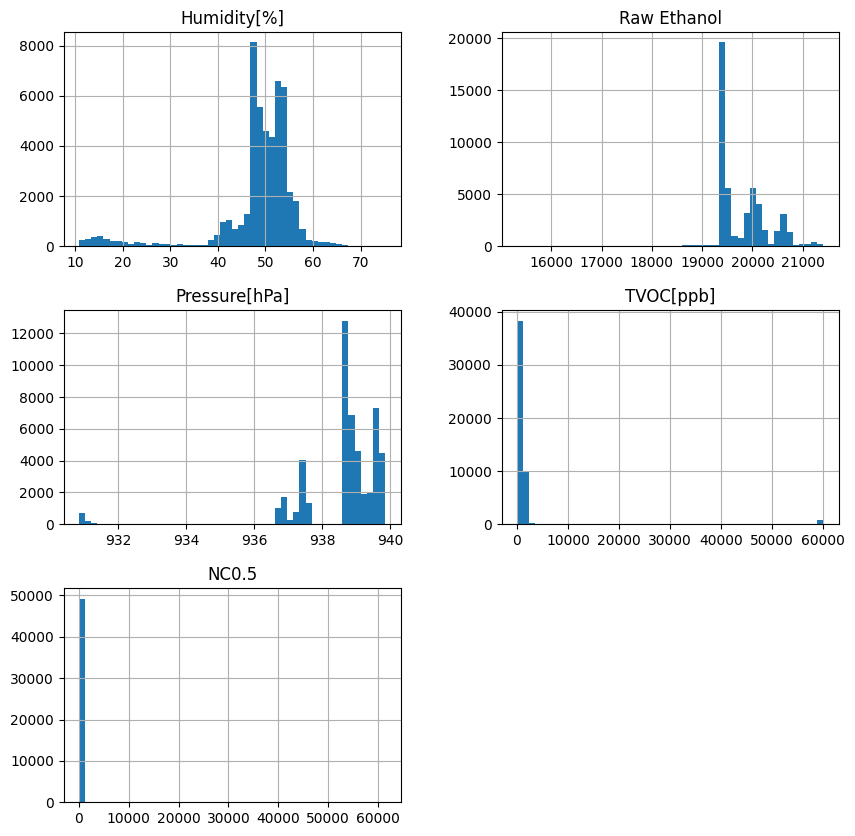

In [144]:
#X_train_5f_scaled, X_test_5f_scaled, Y_train_5f, Y_test_5f = train_test_split(X_5f, Y_df, test_size=0.2, random_state=0)

X_train_5f.hist(
    figsize=(10, 10),
    bins=50
    )

## Histogram Analysis
- The majority of the data in the NC0.5 feature lies below 30, and the majority of the data in the TVOC feature lies below 1500
- By removing the data above these thresholds, we can remove the bias from the data and produce a much more even distribution

Data reduction: 5.79%


array([[<Axes: title={'center': 'Humidity[%]'}>,
        <Axes: title={'center': 'Raw Ethanol'}>],
       [<Axes: title={'center': 'Pressure[hPa]'}>,
        <Axes: title={'center': 'TVOC[ppb]'}>],
       [<Axes: title={'center': 'NC0.5'}>, <Axes: >]], dtype=object)

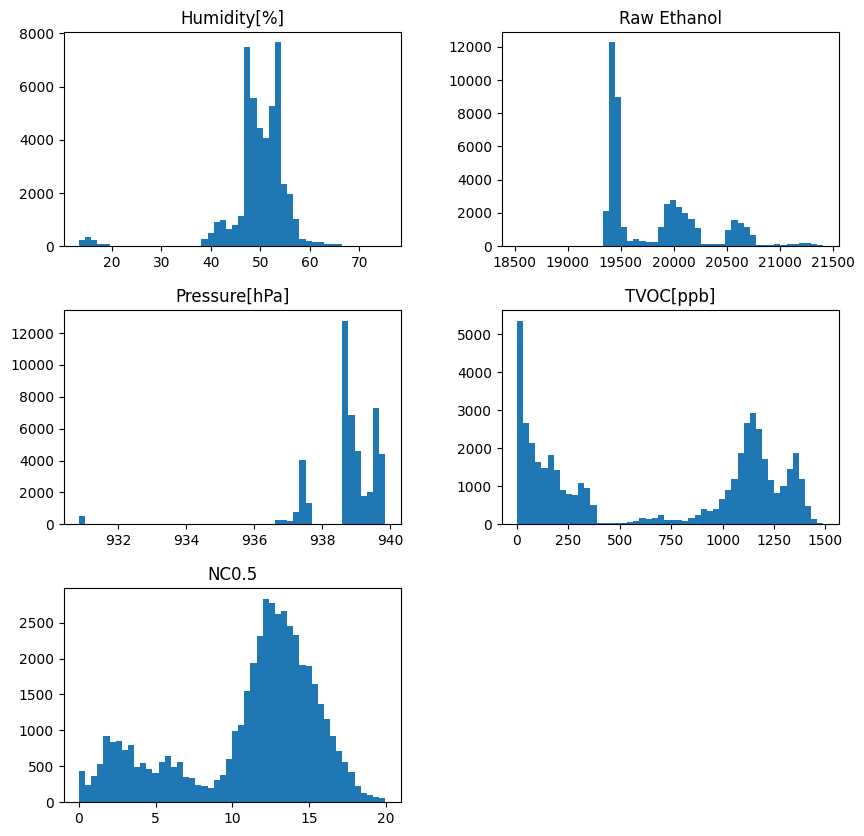

In [145]:
import matplotlib.pyplot as plt

TVOC_threshold = 1500
NC0_5_threshold = 20

X_train_outlier, X_test_outlier, Y_train_outlier, Y_test_outlier = train_test_split(X_5f, Y_df, test_size=0.2, random_state=0)

X_train_outlier =  X_train_outlier[(X_train_outlier['TVOC[ppb]'] < TVOC_threshold) & (X_train_outlier['NC0.5'] < NC0_5_threshold)]
Y_train_outlier = Y_train_outlier[X_train_outlier.index]

data_reduction = 100*(1 - X_train_outlier.shape[0] / X_train_5f_scaled.shape[0])
print(f'Data reduction: {data_reduction:.2f}%')

X_train_outlier.hist(
    figsize=(10, 10),
    grid=False,
    bins=50
)

## Improved Distribution
- The training data is much more evenly distributed.
- However, it does not make sense to apply this filter to the validation data, as the real sensor values will follow the original distribution

----------------------------------------
| Epoch | Training Loss |  Test Loss   |
----------------------------------------
|     0 |  0.6899681687 | 0.6883749962 |
----------------------------------------
|   500 |  0.1994942129 | 0.3116412461 |
----------------------------------------
|  1000 |  0.1112565622 | 0.2439231724 |
----------------------------------------
|  1500 |  0.0968885273 | 0.3521610200 |
----------------------------------------
|  2000 |  0.0774946511 | 2.1788771152 |
----------------------------------------
|  2500 |  0.0444275141 | 2.6781725883 |
----------------------------------------
|  2999 |  0.0233184807 | 3.2689745426 |
----------------------------------------
Accuracy: 0.9505827878013732
Precision: 0.9392592592592592
Recall: 0.9949557224526399
F1: 0.9663055903325894
Confusion_matrix:
[[3031  574]
 [  45 8876]]
Classification_report:               precision    recall  f1-score   support

         0.0       0.99      0.84      0.91      3605
         1.0     

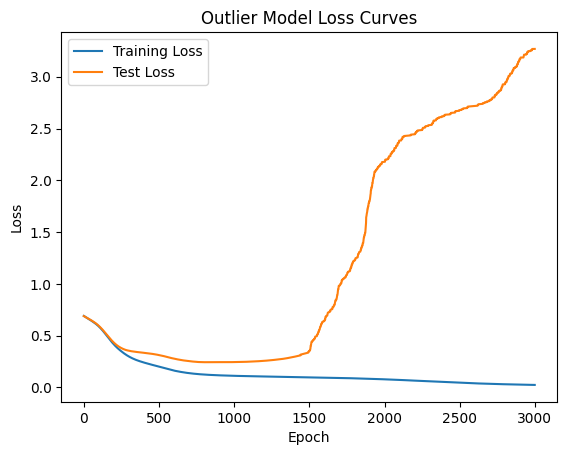

In [146]:
#remove all rows where TVOC>3000 or NC0.5>4000

scaler = StandardScaler()
scaler.fit(X_train_5f)
X_train_outlier_scaled = scaler.transform(X_train_outlier)
X_test_outlier_scaled = scaler.transform(X_test_5f)


X_train_outlier_device = torch.tensor(X_train_outlier_scaled).float().to(device)
X_test_outlier_device = torch.tensor(X_test_outlier_scaled).float().to(device)
Y_train_outlier_device = torch.tensor(Y_train_outlier.values).float().view(-1, 1).to(device)
Y_test_outlier_device = torch.tensor(Y_test_5f.values).float().view(-1, 1).to(device)

outlier_model = AlarmNet(
    num_features=X_train_outlier.shape[1],
    activation = nn.ReLU,
    hidden_layers=[64, 128, 64]
).to(device)

outlier_model.train(
    epochs=3000,
    X_train=X_train_outlier_device,
    X_test=X_test_outlier_device,
    Y_train=Y_train_outlier_device,
    Y_test=Y_test_outlier_device,
    alpha=1e-4,
    print_epoch = 500
)
outlier_model.print_results()
AlarmNet.compare_results(outlier_model.get_results(), dropped_model_5_results)
outlier_model.plot_training("Outlier Model Loss Curves")


# Imputation
- The training and validation datasets have completely different distributions
    - This causes overfitting
- Solution: Imputation
    - Replace each value above the threshold with the median of the feature
    - Chose median because it is a better measure of center than mean for skewed distributions


(50104,)
(50104, 5)
(50104, 5)
(50104, 5)
(50104, 5)


array([[<Axes: title={'center': 'Humidity[%]'}>,
        <Axes: title={'center': 'Raw Ethanol'}>],
       [<Axes: title={'center': 'Pressure[hPa]'}>,
        <Axes: title={'center': 'TVOC[ppb]'}>],
       [<Axes: title={'center': 'NC0.5'}>, <Axes: >]], dtype=object)

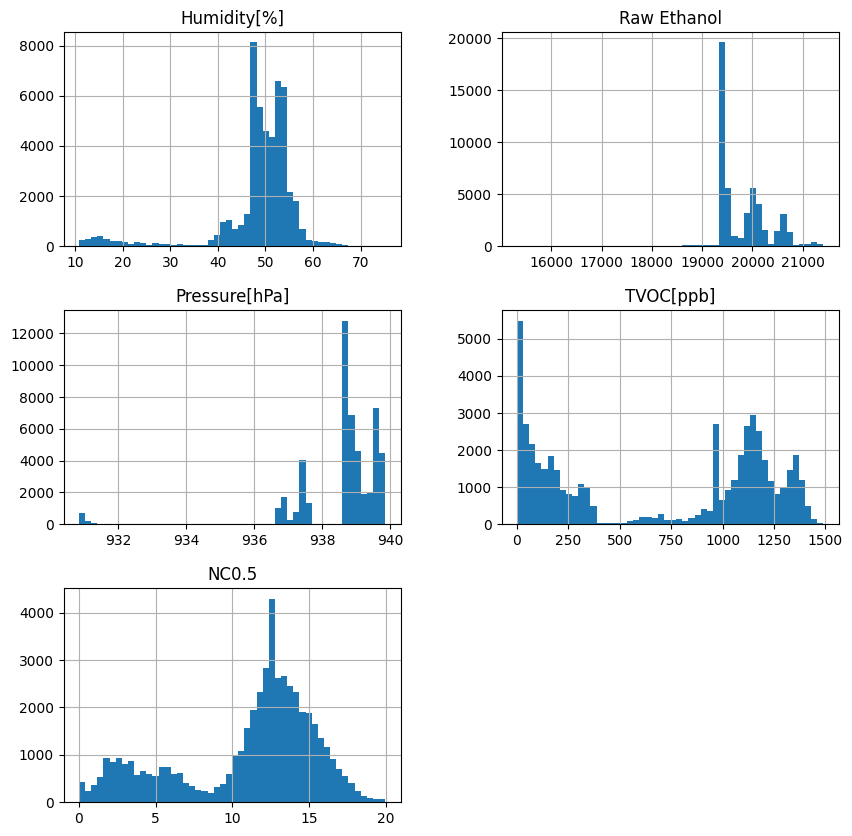

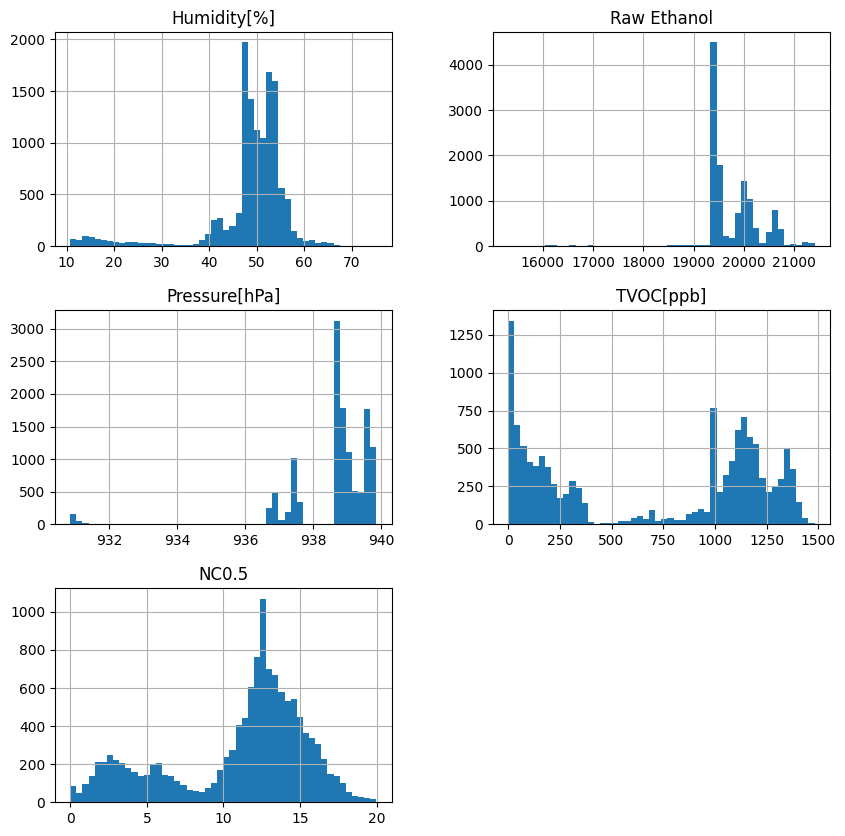

In [168]:

X_train_imputed, X_test_imputed, Y_train_imputed, Y_test_imputed = train_test_split(X_5f, Y_df.values, test_size=0.2, random_state=0)
print(Y_train_imputed.shape)
print(X_train_imputed.shape)

def impute_single(x, threshold, replacement):
    return replacement if (x > threshold or x == np.nan) else x

TVOC_threshold = 1500
NC0_5_threshold = 20
median = X_train_5f.median()

print(X_train_imputed.shape)
X_train_imputed['TVOC[ppb]'] = X_train_imputed['TVOC[ppb]'].apply(impute_single, args=(TVOC_threshold, median['TVOC[ppb]']))
X_train_imputed['NC0.5'] = X_train_imputed['NC0.5'].apply(impute_single, args=(NC0_5_threshold, median['NC0.5']))
print(X_train_imputed.shape)
X_test_imputed['TVOC[ppb]'] = X_test_imputed['TVOC[ppb]'].apply(impute_single, args=(TVOC_threshold, median['TVOC[ppb]']))
X_test_imputed['NC0.5'] = X_test_imputed['NC0.5'].apply(impute_single, args=(NC0_5_threshold, median['NC0.5']))
print(X_train_imputed.shape)
X_train_imputed.hist(
    figsize=(10, 10),
    bins=50
)
X_test_imputed.hist(
    figsize=(10, 10),
    bins=50
)
# print(X_train_5f.shape)
# print(X_train_imputed.shape)
# print(Y_train_imputed.shape)

/home/jaskin/.local/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/jaskin/.local/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


----------------------------------------
| Epoch | Training Loss |  Test Loss   |
----------------------------------------
|     0 |  0.6512335539 | 0.6436043382 |
----------------------------------------
|   500 |  0.0073131481 | 0.0095016360 |
----------------------------------------
|  1000 |  0.0023214198 | 0.0036415448 |
----------------------------------------
|  1500 |  0.0014393317 | 0.0023838244 |
----------------------------------------
|  2000 |  0.0011272806 | 0.0018098791 |
----------------------------------------
|  2500 |  0.0009422101 | 0.0014375155 |
----------------------------------------
|  2999 |  0.0007993764 | 0.0011718584 |
----------------------------------------
Accuracy: 0.9997604981638193
Precision: 0.9997758350145707
Recall: 0.999887904943392
F1: 0.9998318668385361
Confusion_matrix:
[[3603    2]
 [   1 8920]]
Classification_report:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3605
         1.0      

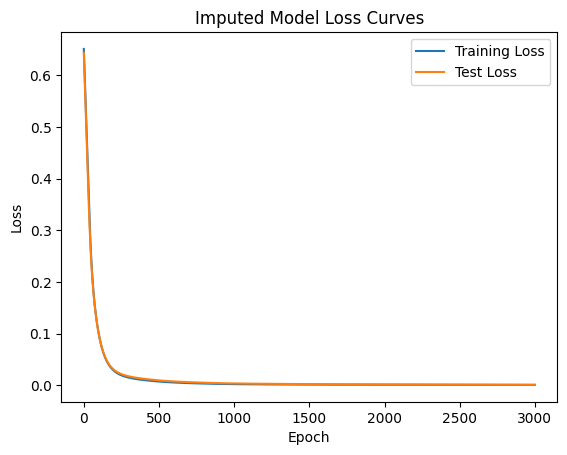

In [169]:
X_train_imputed_device = torch.tensor(scaler.transform(X_train_imputed)).float().to(device)
X_test_imputed_device = torch.tensor(scaler.transform(X_test_imputed)).float().to(device)
Y_train_imputed_device = torch.tensor(Y_train_imputed).float().view(-1, 1).to(device)
Y_test_imputed_device = torch.tensor(Y_test_imputed).float().view(-1, 1).to(device)

imputed_model = AlarmNet(
    num_features=X_train_imputed.shape[1],
    activation = nn.ReLU,
    hidden_layers=[64, 64]
).to(device)

imputed_model.train(
    epochs=3000,
    X_train=X_train_imputed_device,
    X_test=X_test_imputed_device,
    Y_train=Y_train_imputed_device,
    Y_test=Y_test_imputed_device,
    alpha=1e-3,
    print_epoch = 500
)

imputed_model.print_results()
AlarmNet.compare_results(imputed_model.get_results(), dropped_model_5_results)
imputed_model.plot_training("Imputed Model Loss Curves")


In [149]:
import random

# Introduce sensor errors

VOC_features = [
    'TVOC[ppb]',
    'eCO2[ppm]',
    'Raw H2',
    'Raw Ethanol'
]

PM_features = [
    'PM1.0',
    'PM2.5',
    'NC0.5',
    'NC1.0',
    'NC2.5'
]

th_features = [
    'Temperature[C]',
    'Humidity[%]'
]
pressure_features = [
    'Pressure[hPa]'
]

# For each measurement, each sensor has this chance of introducing an error
error_chance = 0.2

# The PM sensor is twice as likely to fail due to lack of redundancy
chances = [error_chance, error_chance*2, error_chance, error_chance]
sensors = [VOC_features, PM_features, th_features, pressure_features]


X_error_np = X_outlier.values.copy()
for i, datapoint in enumerate(X_error_np):
    errored_features = []
    for j, sensor in enumerate(sensors):
        sensor_error = random.random() < chances[j]
        if sensor_error:
            errored_features.extend(sensor)
    errored_features = [feature for feature in errored_features if feature in X_5f.columns]
    if errored_features:
        for feature in errored_features:
            X_error_np[i][X_outlier.columns.get_loc(feature)] = np.nan
        # print(i, X_error_np[i])

X_train_error, X_test_error, Y_train_error, Y_test_error = train_test_split(X_error_np, Y_outlier.values, test_size=0.2, random_state=0)


# Error Handling
- The 12 initial features came from 4 sensors
    - Temp/Humidity
    - Pressure
    - Volatile Organic Compounds (CO2, Ethanol, H2, TVOC)
    - Particulate Matter (PM1, PM2.5, NC0.5, NC1, NC2.5)
- 3 of these sensors are redundant, with the exception being the PM sensor
    - This means that the features related to the PM sensor are twice as likely to be missing
- We can simulate a real world scenario by introducing error according to this distribution

## Imputation
- Replace each errored value with the mean of that feature from the training data

In [150]:
from sklearn.impute import SimpleImputer


means = X_5f.mean()



imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_5f.values)
imputer.fit(X_train_error)
X_impute_train = imputer.transform(X_train_error)
X_impute_test = imputer.transform(X_test_error)

X_impute_train = scaler.fit_transform(X_impute_train)
X_impute_test = scaler.transform(X_impute_test)

In [151]:
imputed_model = AlarmNet(
    num_features=X_impute_train.shape[1],
    activation = nn.ReLU,
    hidden_layers=[256, 256, 256]
    
).to(device)

X_impute_train_device = torch.tensor(X_impute_train).float().to(device)
X_impute_test_device = torch.tensor(X_impute_test).float().to(device)
Y_train_impute_device = torch.tensor(Y_train_error).float().view(-1, 1).to(device)
Y_test_impute_device = torch.tensor(Y_test_error).float().view(-1, 1).to(device)

imputed_model.train(
    epochs= 10000,
    X_train = X_impute_train_device,
    X_test = X_impute_test_device,
    Y_train = Y_train_impute_device,
    Y_test = Y_test_impute_device,
    alpha= 1e-4,
    loss_fn = nn.BCELoss(),
    optimizer = torch.optim.Adam
)
imputed_model.print_results()
AlarmNet.compare_results(imputed_model.get_results(), dropped_model_5.get_results())
imputed_model.plot_training("Imputed Model Loss Curves")

----------------------------------------
| Epoch | Training Loss |  Test Loss   |
----------------------------------------
|     0 |  0.6810419559 | 0.6761488914 |
----------------------------------------
|   500 |  0.0650570467 | 0.0603600405 |
----------------------------------------
|  1000 |  0.0409282520 | 0.0378978103 |
----------------------------------------
|  1500 |  0.0350565426 | 0.0331667177 |
----------------------------------------
|  2000 |  0.0323385149 | 0.0312803984 |
----------------------------------------


KeyboardInterrupt: 

## Error Modes
- Current features:
    - Humidity
    - Raw Ethanol
    - Pressure
    - TVOC
    - NC0.5
- Sensors:
    - Humidity
    - Pressure
    - Raw Ethanol/TVOC
    - NC0.5
- The model should be able to handle missing data in the case where at most 3 sensors have failed, because 4 failed sensors means no data
    - 1 failed sensor = 4c1 = 4
    - 2 failed sensors = 4c2 = 6
    - 3 failed sensors = 4c3 = 4
    - Total = 14
## Ensemble Training
- We can train 14 models that can predict the missing data for each error mode
- In the case of error, we select the model that corresponds to the error mode and use it to predict the missing data
- Then use the main model to predict the target
### Indexing Ensemble
- Columns should be rearranged according to sensors
    - Humidity, Pressure, NC0.5, Ethanol, TVOC, 
- The error mode can be represented as a 4-bit value
    - 0b0000 = No error
    - 0b0001 = Ethanol/TVOC Error
    - 0b0010 = NC0.5 Error
    - 0b0100 = Pressure error
    - 0b1000 = Humidity error
- A 5-bit value can represent which features are missing
    - 0b00000 = No error
    - 0b00011 = Ethanol/TVOC Error
    - 0b00100 = NC0.5 Error
    - 0b01000 = Pressure error
    - 0b10000 = Humidity error
- We can convert from the 5-bit value to the 4-bit value with a simple shift right operation

### Model Table
- Store the models with an array
- The index of the model is the error mode
- Model 15 will always predict 1, because if all sensors have failed the worst should be assumed for safety
- Model 0 will be the standard model trained on a full dataset
- The rest of the arrays will be trained on the data with the corresponding error mode
### New Model Type
- A new model class will be created that will predict the missing values, construct the repaired dataset, call the standard model, and return the result
### Ensemble Class
- This new class will hold the model table and the standard model
- It will be responsible for constructing the model address, calling the correct model, and returning the result



    

